# Position Reconstruction for XeBRA - Centroids - Measurements Analysis

**Status:** August 2019

Position reconstruction for XeBRA using centroids.

In [1]:
## Imports:

import sys
import glob

import numpy as np
from numpy import exp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from matplotlib.image import NonUniformImage
from matplotlib.patches import Rectangle
%matplotlib inline

import pandas as pd
import math

from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import griddata
from scipy.stats import chisquare
from scipy.stats import power_divergence

## General Definitions and Parameters

In [2]:
#### General function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [3]:
## PMT properties

R8520_body_width = 25.7
R8520_body_cornerradius = 2.
R8520_photocathode_width = 20.5
R8520_photocathode_cornerradius = 1.

PMT_ID = np.array([1,2,3,4,5,6,7])

PMT_position_x = np.array([-14.,-28,-14.,14.,28.,14.,0.])      # x-position PMTs in mm in cartesian coordinates
PMT_position_y = np.array([-28.,0.,28.,28.,0.,-28.,0.])        # y-position PMTs in mm in cartesian coordinates
PMT_position_R = f_polar_R(PMT_position_x, PMT_position_y)     # radial position PMTs in mm in polar coordinates
PMT_position_Phi = f_polar_Phi(PMT_position_x, PMT_position_y) # angular position PMTs in rad in polar coordinates

PMT_positions = pd.DataFrame(index=PMT_ID, data={'PMT_ID': PMT_ID, 'PMT_position_x': PMT_position_x, 'PMT_position_y': PMT_position_y, 'PMT_position_R': PMT_position_R, 'PMT_position_Phi': PMT_position_Phi})
PMT_positions

,PMT_ID,PMT_position_x,PMT_position_y,PMT_position_R,PMT_position_Phi
1,1,-14.0,-28.0,31.304952,-2.034444
2,2,-28.0,0.0,28.000000,3.141593
3,3,-14.0,28.0,31.304952,2.034444
4,4,14.0,28.0,31.304952,1.107149
5,5,28.0,0.0,28.000000,0.000000
6,6,14.0,-28.0,31.304952,-1.107149
7,7,0.0,0.0,0.000000,0.000000


## Imports and Data Processing

In [4]:
## Selection of file to be analyzed:
#filename = '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_3.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse.root'
#filename_list = ['/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04.root']
filename_list = glob.glob("/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_*.root")

if len(filename_list) == 1:    
    filename = filename_list[0]  
else:   
    exec('n_events = '+str(len(filename_list))+'*'+filename_list[0][filename_list[0].find('e+')-3:filename_list[0].find('e+')+4])
    filename       = filename_list[0][:filename_list[0].find('e+')-3]+"{:.1e}".format(n_events)+filename_list[0][filename_list[0].find('e+')+4:-7]+'.root'
 
# filename prefix for automatically naming outputs

if filename[6:14] == 'Xebra_G4':
    filenameprefix = filename[:-5][15:]
    
elif filename[6:25] == 'Simulation_Data/Mod':
    filenameprefix = filename[:-5][44:]
    
elif filename[6:25] == 'Simulation_Data/LCE':
    filenameprefix = filename[:-5][26:]
    
elif filename[:45] == '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/':
    filenameprefix = filename[:-5][45:]
    
elif filename[:63] == '/media/ab602/TOSHIBA EXT/Simulation_Data/Modification_Spacer_3/':
    filenameprefix = filename[:-5][63:]
    
elif filename[:70] == '/media/ab602/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/':
    filenameprefix = filename[:-5][70:]
    
elif filename[:44] == '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/':
    filenameprefix = filename[:-5][44:]
    
elif filename[:62] == '/media/alex/TOSHIBA EXT/Simulation_Data/Modification_Spacer_3/':
    filenameprefix = filename[:-5][62:]
    
elif filename[:69] == '/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/':
    filenameprefix = filename[:-5][69:]

else:
    filenameprefix = 'filenameprefix'
    
filenameprefix = 'MCfakemeasurement_' + filenameprefix

In [5]:
print(filenameprefix)

MCfakemeasurement_optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04


In [6]:
## Import as pandas dataframes

import uproot
import pandas as pd

branches= ['xp_pri','yp_pri','zp_pri','nbpmthits','ntpmthits','pmthits'] # Be careful that the branches are also initilized in _chunk_collect

import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(8)

_chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [],'nbpmthits' : [],'ntpmthits' : [],'pmthits' : []}) # Initialize empty data frame

for _chunk in uproot.iterate(filename_list, "events/events",branches, entrysteps=100000, 
                                       outputtype=pd.DataFrame, executor=executor):
    _chunk.columns=branches
    _chunk_collect = _chunk_collect.append(_chunk)
    print('.', end = '')
print('\n')
    
if filenameprefix.find('nop') > 0:
    nop_string = filenameprefix[(filenameprefix.find('nop')+4) : (filenameprefix.find('+', filenameprefix.find('nop')+4)+3)]
    exec('nop = '+nop_string)
    print('nop = '+str(nop))
    _chunk_collect['nbpmthits'] = _chunk_collect['nbpmthits'] / nop
    _chunk_collect['ntpmthits'] = _chunk_collect['ntpmthits'] / nop
    _chunk_collect['pmthits'] = _chunk_collect['pmthits'] / nop
else:
    print('Error: Number of particles per event = 1!')
    
## Separate hits for individual PMTs
## Takes a while to calculate...
for i in range(0,8):
    _chunk_collect['pmthits_'+str(i)] = pd.Series(nth_tuple_subentries(np.asarray(_chunk_collect['pmthits']), i), index=_chunk_collect.index)
    print(i, end=' ')
    
## Total PMT hits
_chunk_collect['napmthits'] = pd.Series(_chunk_collect.nbpmthits+_chunk_collect.ntpmthits, index=_chunk_collect.index)

..........

nop = 10000.0
0 1 2 3 4 5 6 7 

In [7]:
HF_list = np.array([np.array(_chunk_collect['pmthits_1'])/np.array(_chunk_collect['ntpmthits']),
                    np.array(_chunk_collect['pmthits_2'])/np.array(_chunk_collect['ntpmthits']), 
                    np.array(_chunk_collect['pmthits_3'])/np.array(_chunk_collect['ntpmthits']),
                    np.array(_chunk_collect['pmthits_4'])/np.array(_chunk_collect['ntpmthits']), 
                    np.array(_chunk_collect['pmthits_5'])/np.array(_chunk_collect['ntpmthits']), 
                    np.array(_chunk_collect['pmthits_6'])/np.array(_chunk_collect['ntpmthits']), 
                    np.array(_chunk_collect['pmthits_7'])/np.array(_chunk_collect['ntpmthits'])])
HF_list_full = HF_list
HF_list_full = HF_list_full.T
print(HF_list_full.shape)
HF_list = HF_list[:,0:20000] # reduce statistics
HF_list = HF_list.T
print(HF_list.shape)

(1000000, 7)
(20000, 7)


## Reconstruction

In [8]:
x_list_full = np.array([np.sum(HF_list_full[i]*PMT_position_x) for i in range(0, HF_list_full.shape[0])])
y_list_full = np.array([np.sum(HF_list_full[i]*PMT_position_y) for i in range(0, HF_list_full.shape[0])])

x_list = np.array([np.sum(HF_list[i]*PMT_position_x) for i in range(0, HF_list.shape[0])])
y_list = np.array([np.sum(HF_list[i]*PMT_position_y) for i in range(0, HF_list.shape[0])])

In [9]:
## Save reconstructed positions in pandas dataframe

d = {'x_pos': x_list_full, 'y_pos': y_list_full}
Reconstruction_Centroid_full = pd.DataFrame(data=d)
Reconstruction_Centroid_full.to_pickle(filenameprefix+"_Reconstruction_Centroid_full.pkl")

d = {'x_pos': x_list, 'y_pos': y_list}
Reconstruction_Centroid = pd.DataFrame(data=d)
Reconstruction_Centroid.to_pickle(filenameprefix+"_Reconstruction_Centroid.pkl")
Reconstruction_Centroid

,x_pos,y_pos
0,11.069510,12.230648
1,18.867099,-0.521880
2,-9.701342,15.409396
3,-13.316129,9.806452
4,12.965309,-7.052790
5,12.094556,-1.042980
6,-2.186593,5.998618
7,17.357202,3.427144
8,-2.916667,17.852201
9,-0.769231,-2.038462


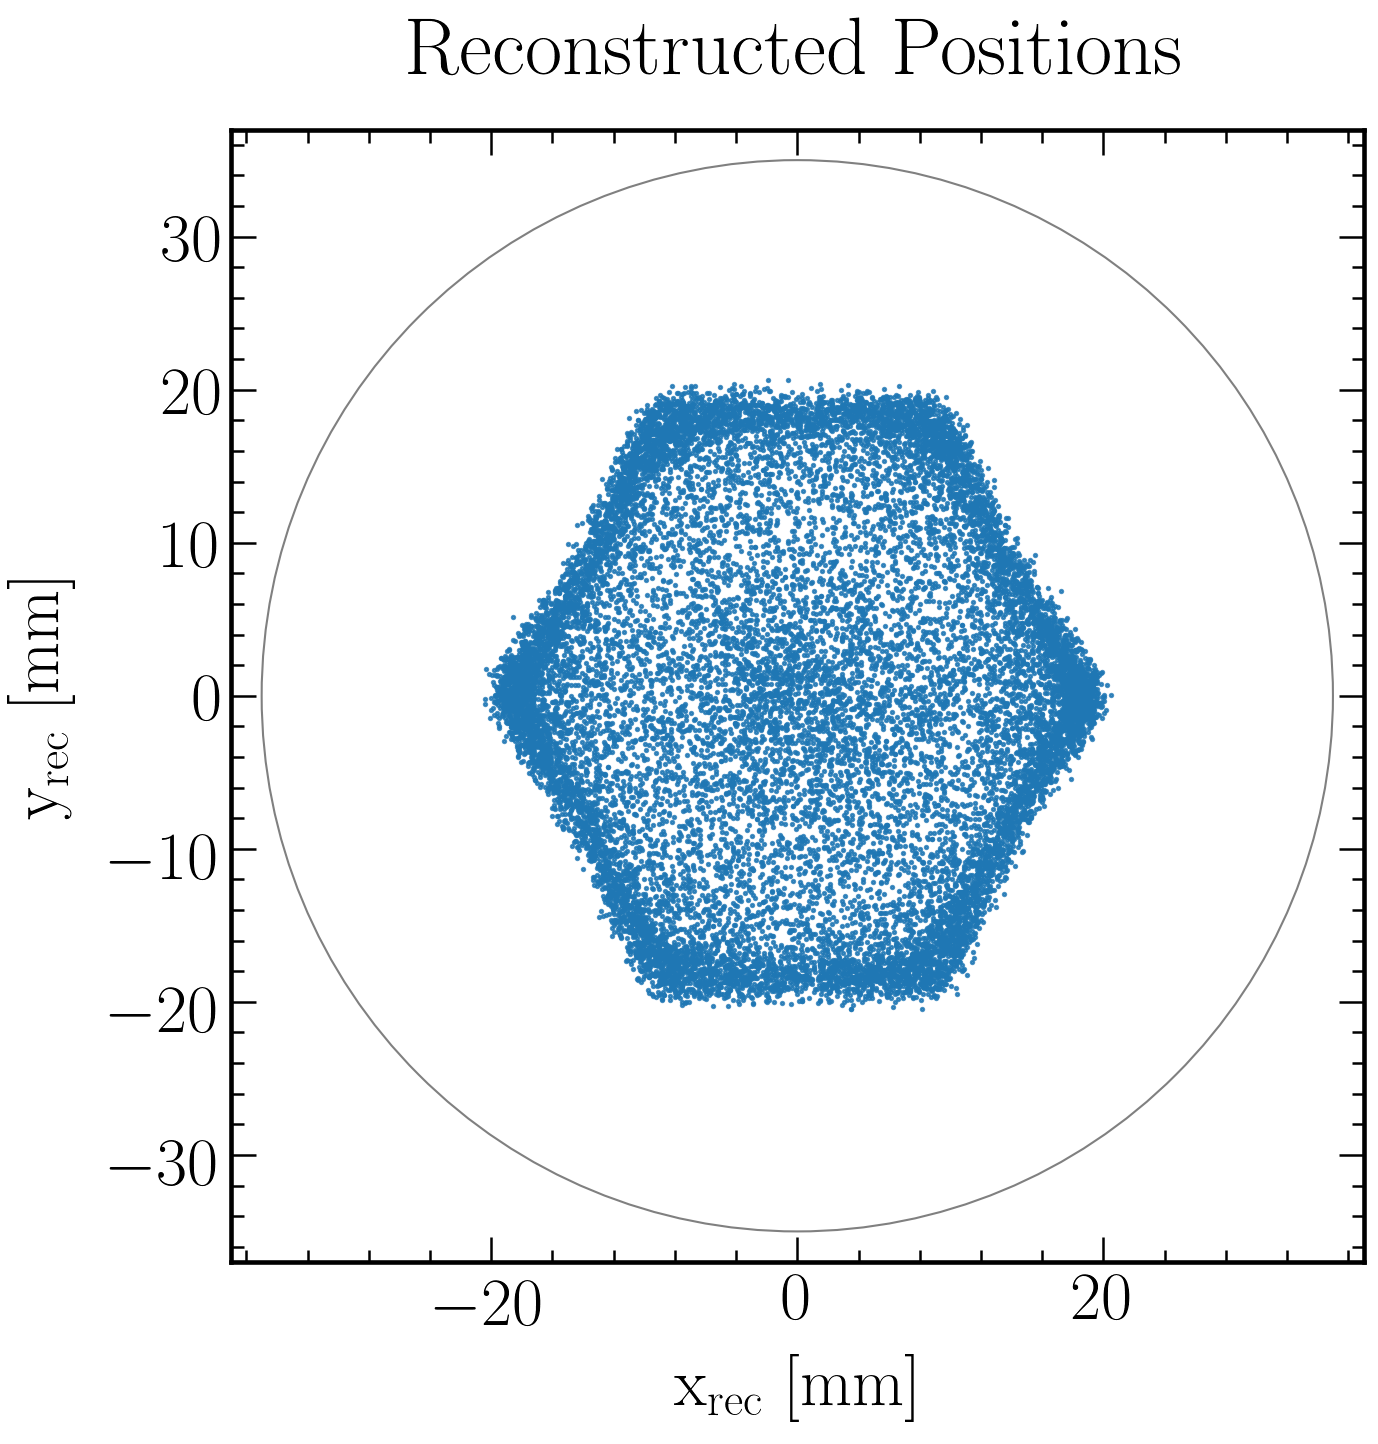

In [10]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
plt.scatter(x_list,
            y_list,
            marker='.',
            #s=1,
            s = 10,
            ##c='k',
            alpha = 0.8,
           )

plt.xlim(-37,37)
plt.ylim(-37,37)

plt.xlabel('x$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions', fontsize = title_size, pad = title_pad)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()
fig.savefig(filenameprefix+"_Centroid.png", bbox_inches = "tight")

## Evaluation

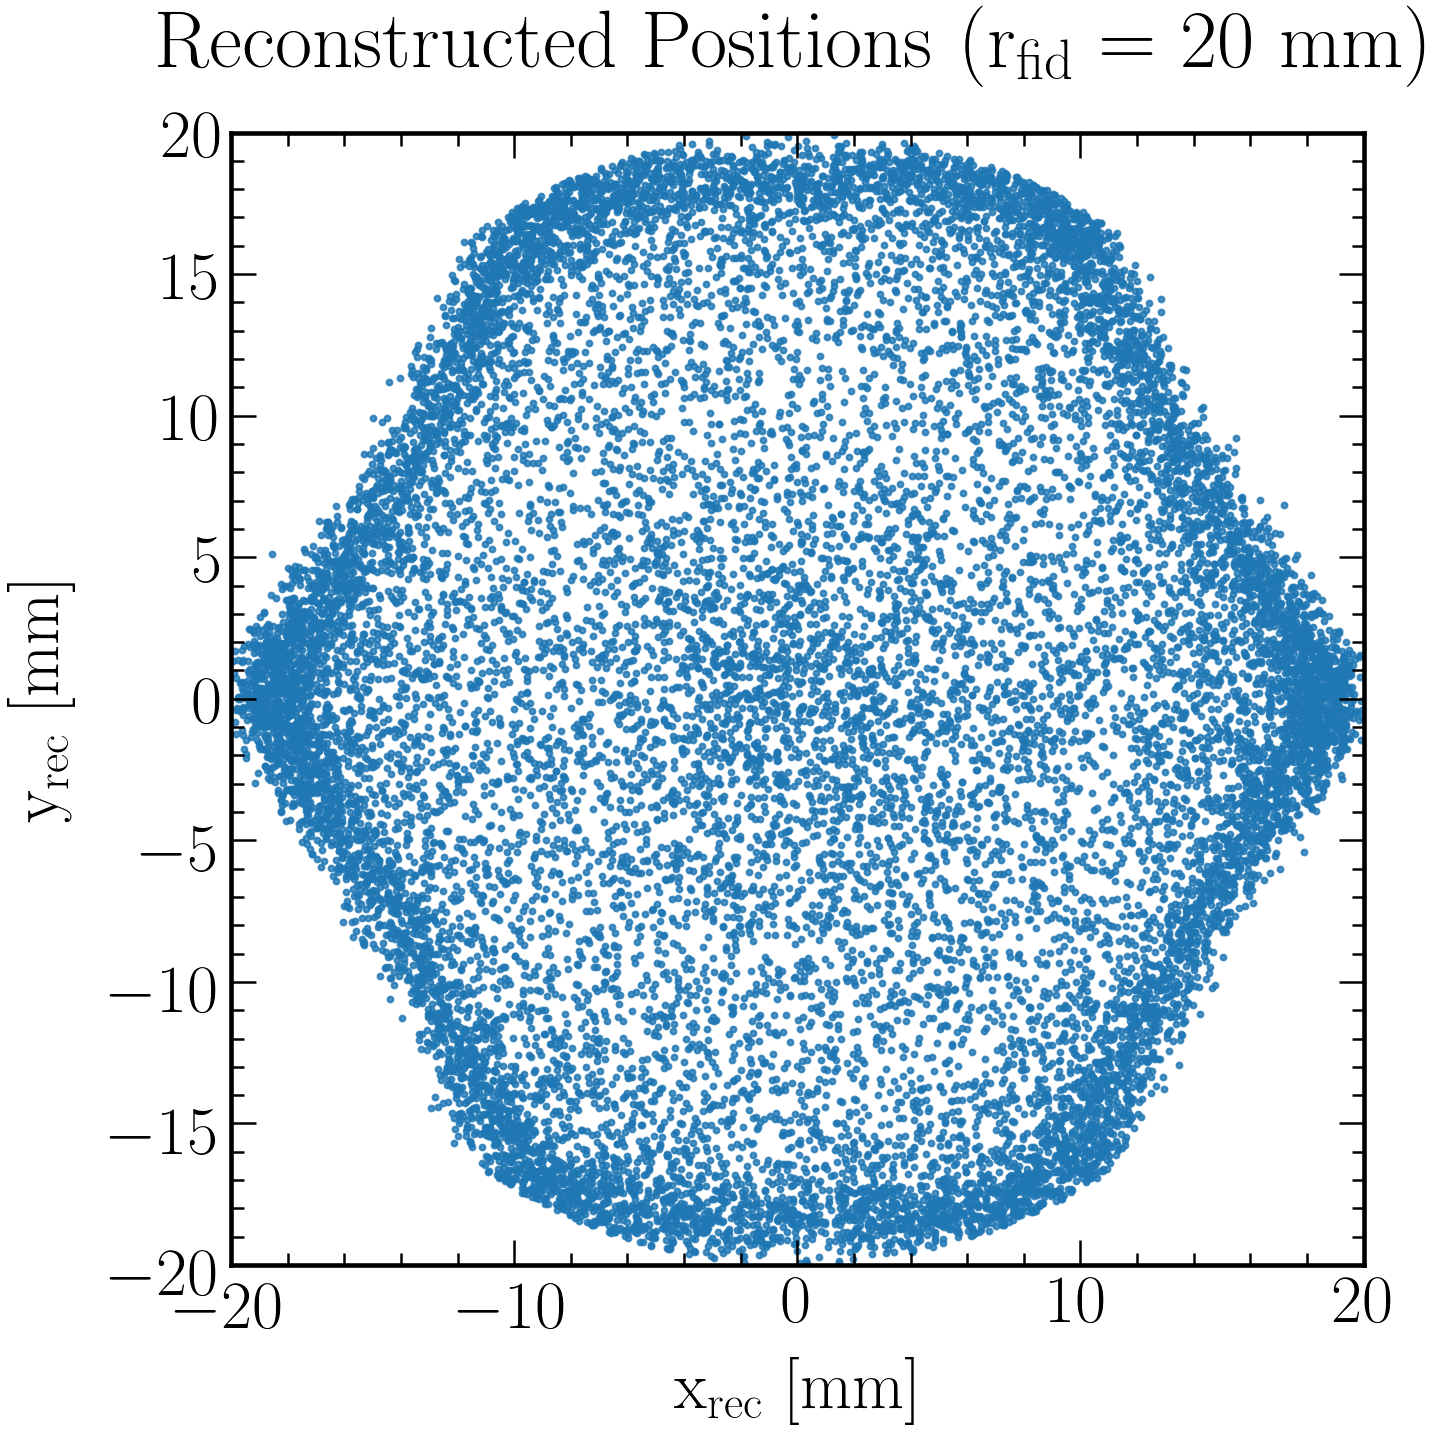

In [11]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
r_fiducial = 20 # fiducial radius in mm
cut_fiducial = np.hypot(x_list, y_list)<r_fiducial

plt.scatter(x_list[cut_fiducial],
            y_list[cut_fiducial],
            marker='.',
            #s=1,
            s = 10*(35/r_fiducial)**2,
            ##c='k',
            alpha = 0.8,
           )

plt.xlim(-r_fiducial,r_fiducial)
plt.ylim(-r_fiducial,r_fiducial)

plt.xlabel('x$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions (r$_\mathrm{fid}$ = '+str(r_fiducial)+' mm)', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()
fig.savefig(filenameprefix+"_Centroid_fid_"+str(r_fiducial)+".png", bbox_inches = "tight")

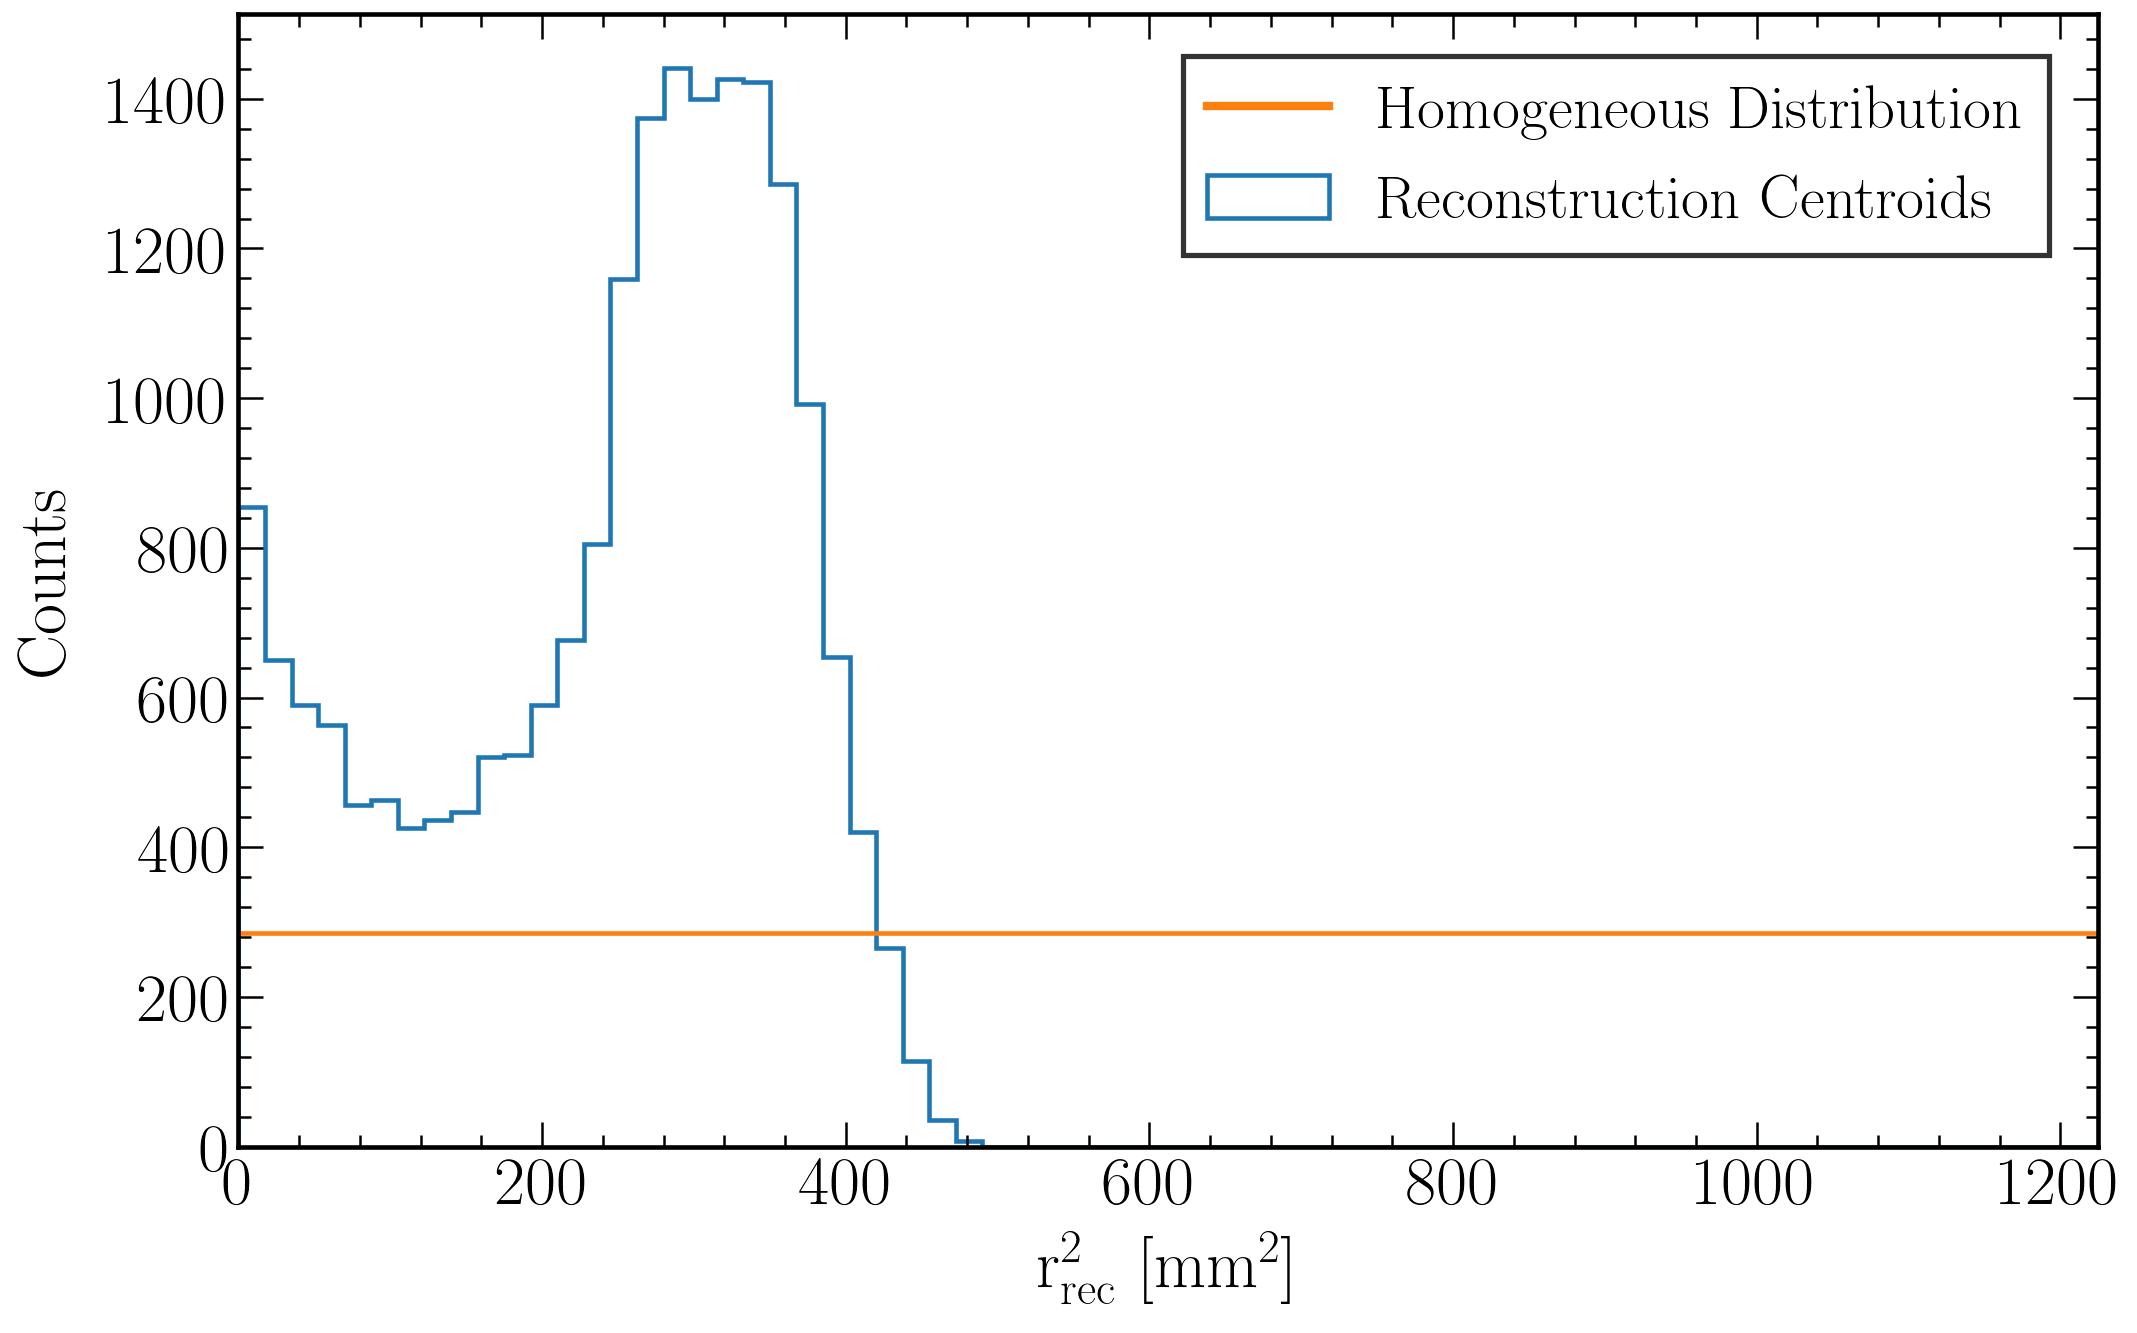

In [12]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.hist(np.hypot(x_list, y_list)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction Centroids')
plt.plot([0, 35**2], [x_list.shape[0]/bns]*2, linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous Distribution')

plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35**2)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_Centroid_r2spectrum.png")
plt.show()

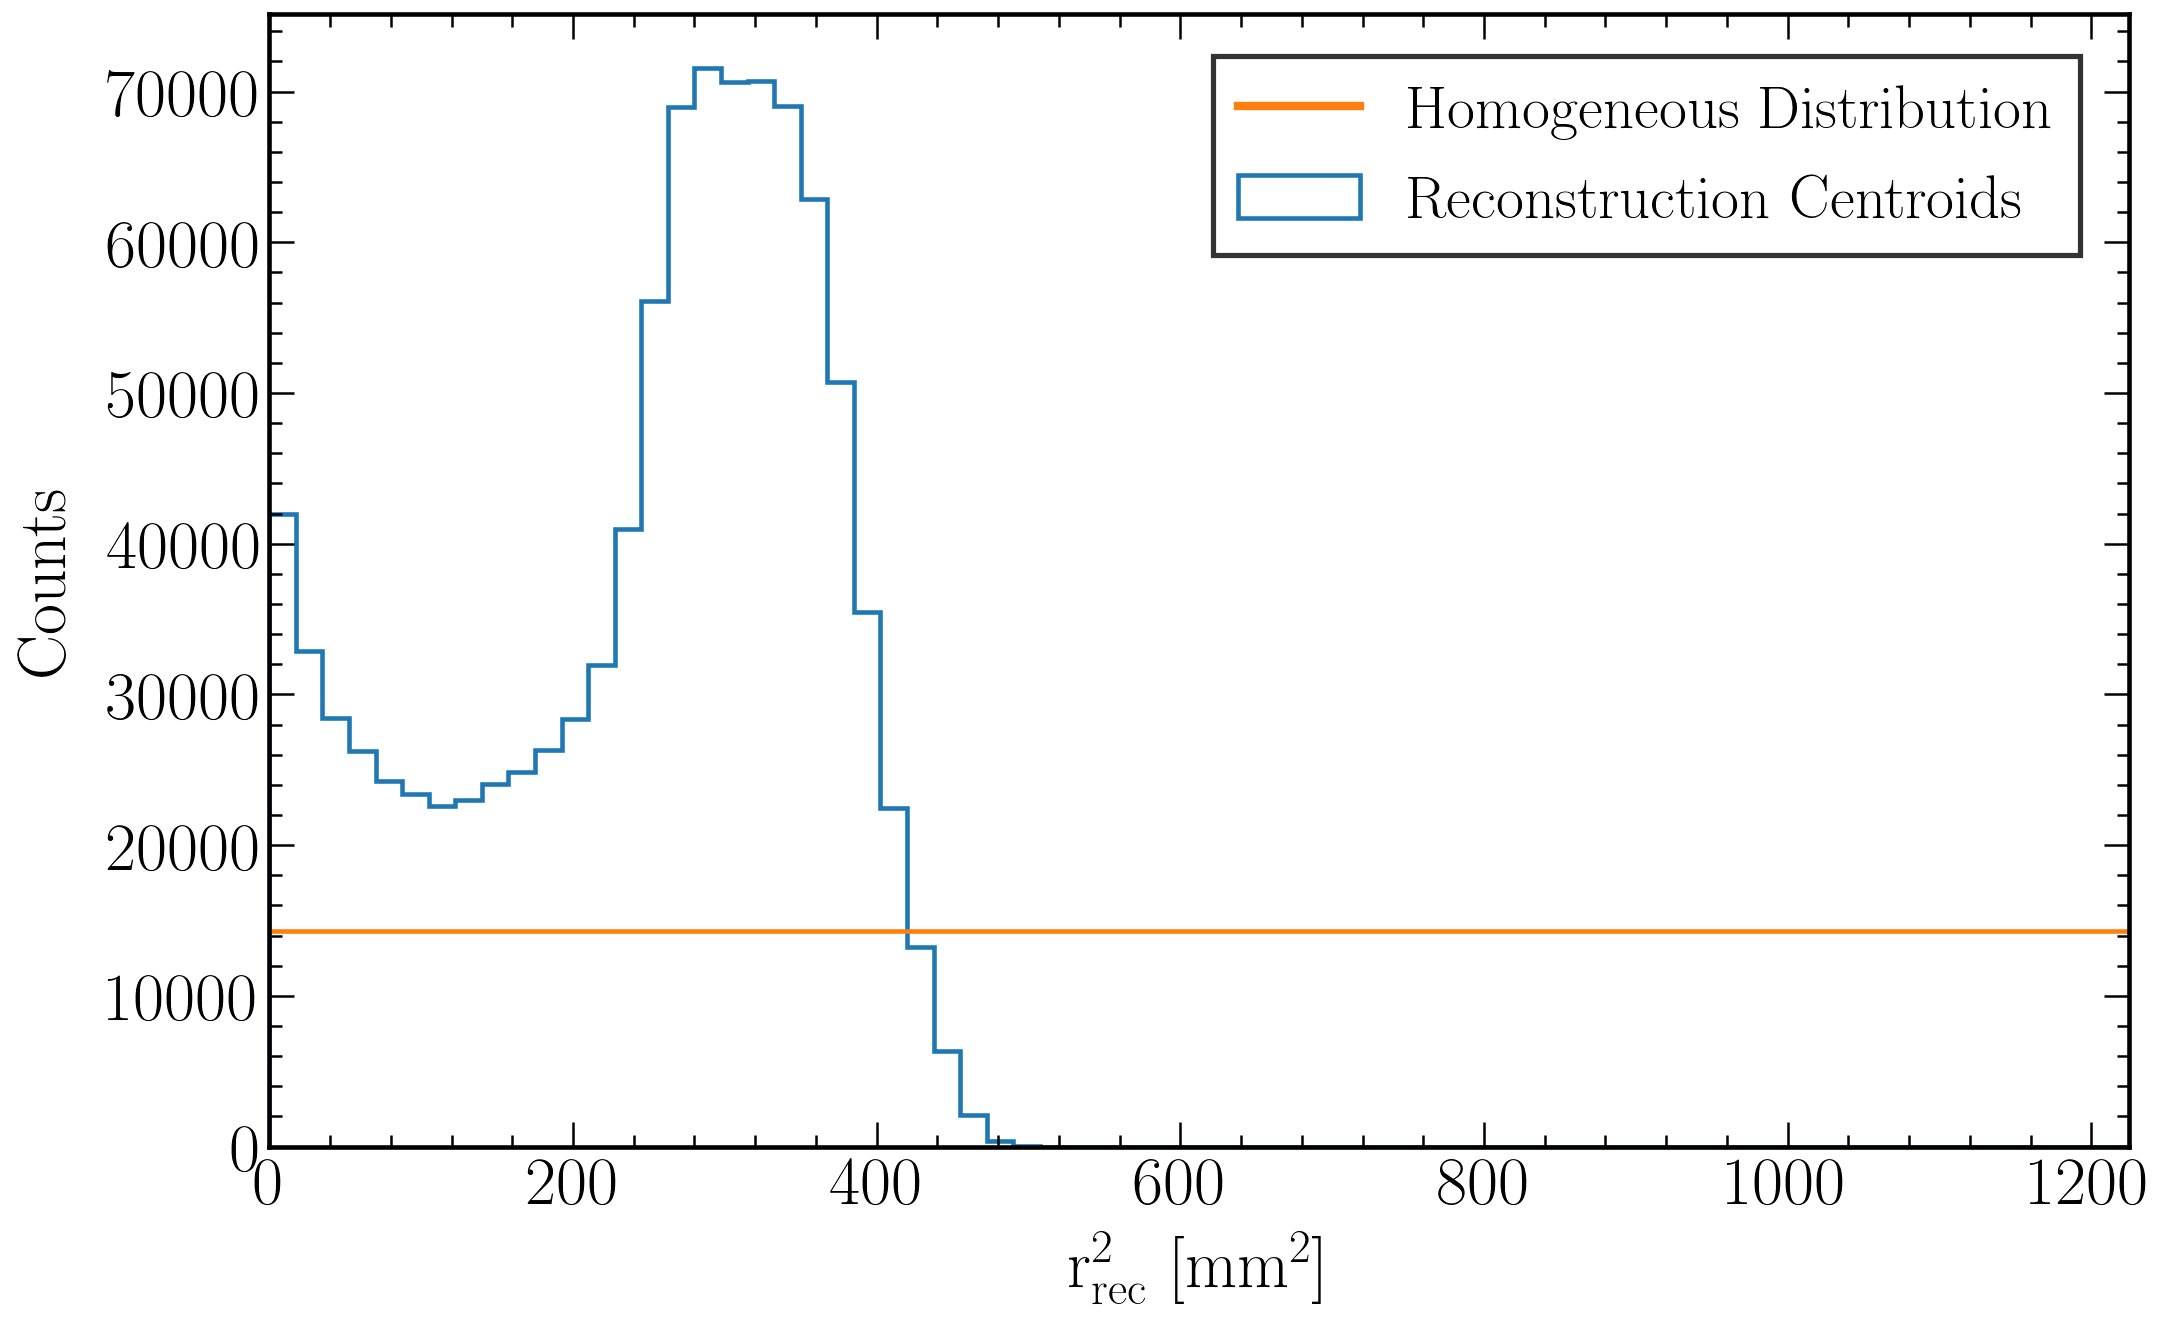

In [13]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.hist(np.hypot(x_list_full, y_list_full)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction Centroids')
plt.plot([0, 35**2], [x_list_full.shape[0]/bns]*2, linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous Distribution')

plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35**2)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_Centroid_full_r2spectrum.png")
plt.show()

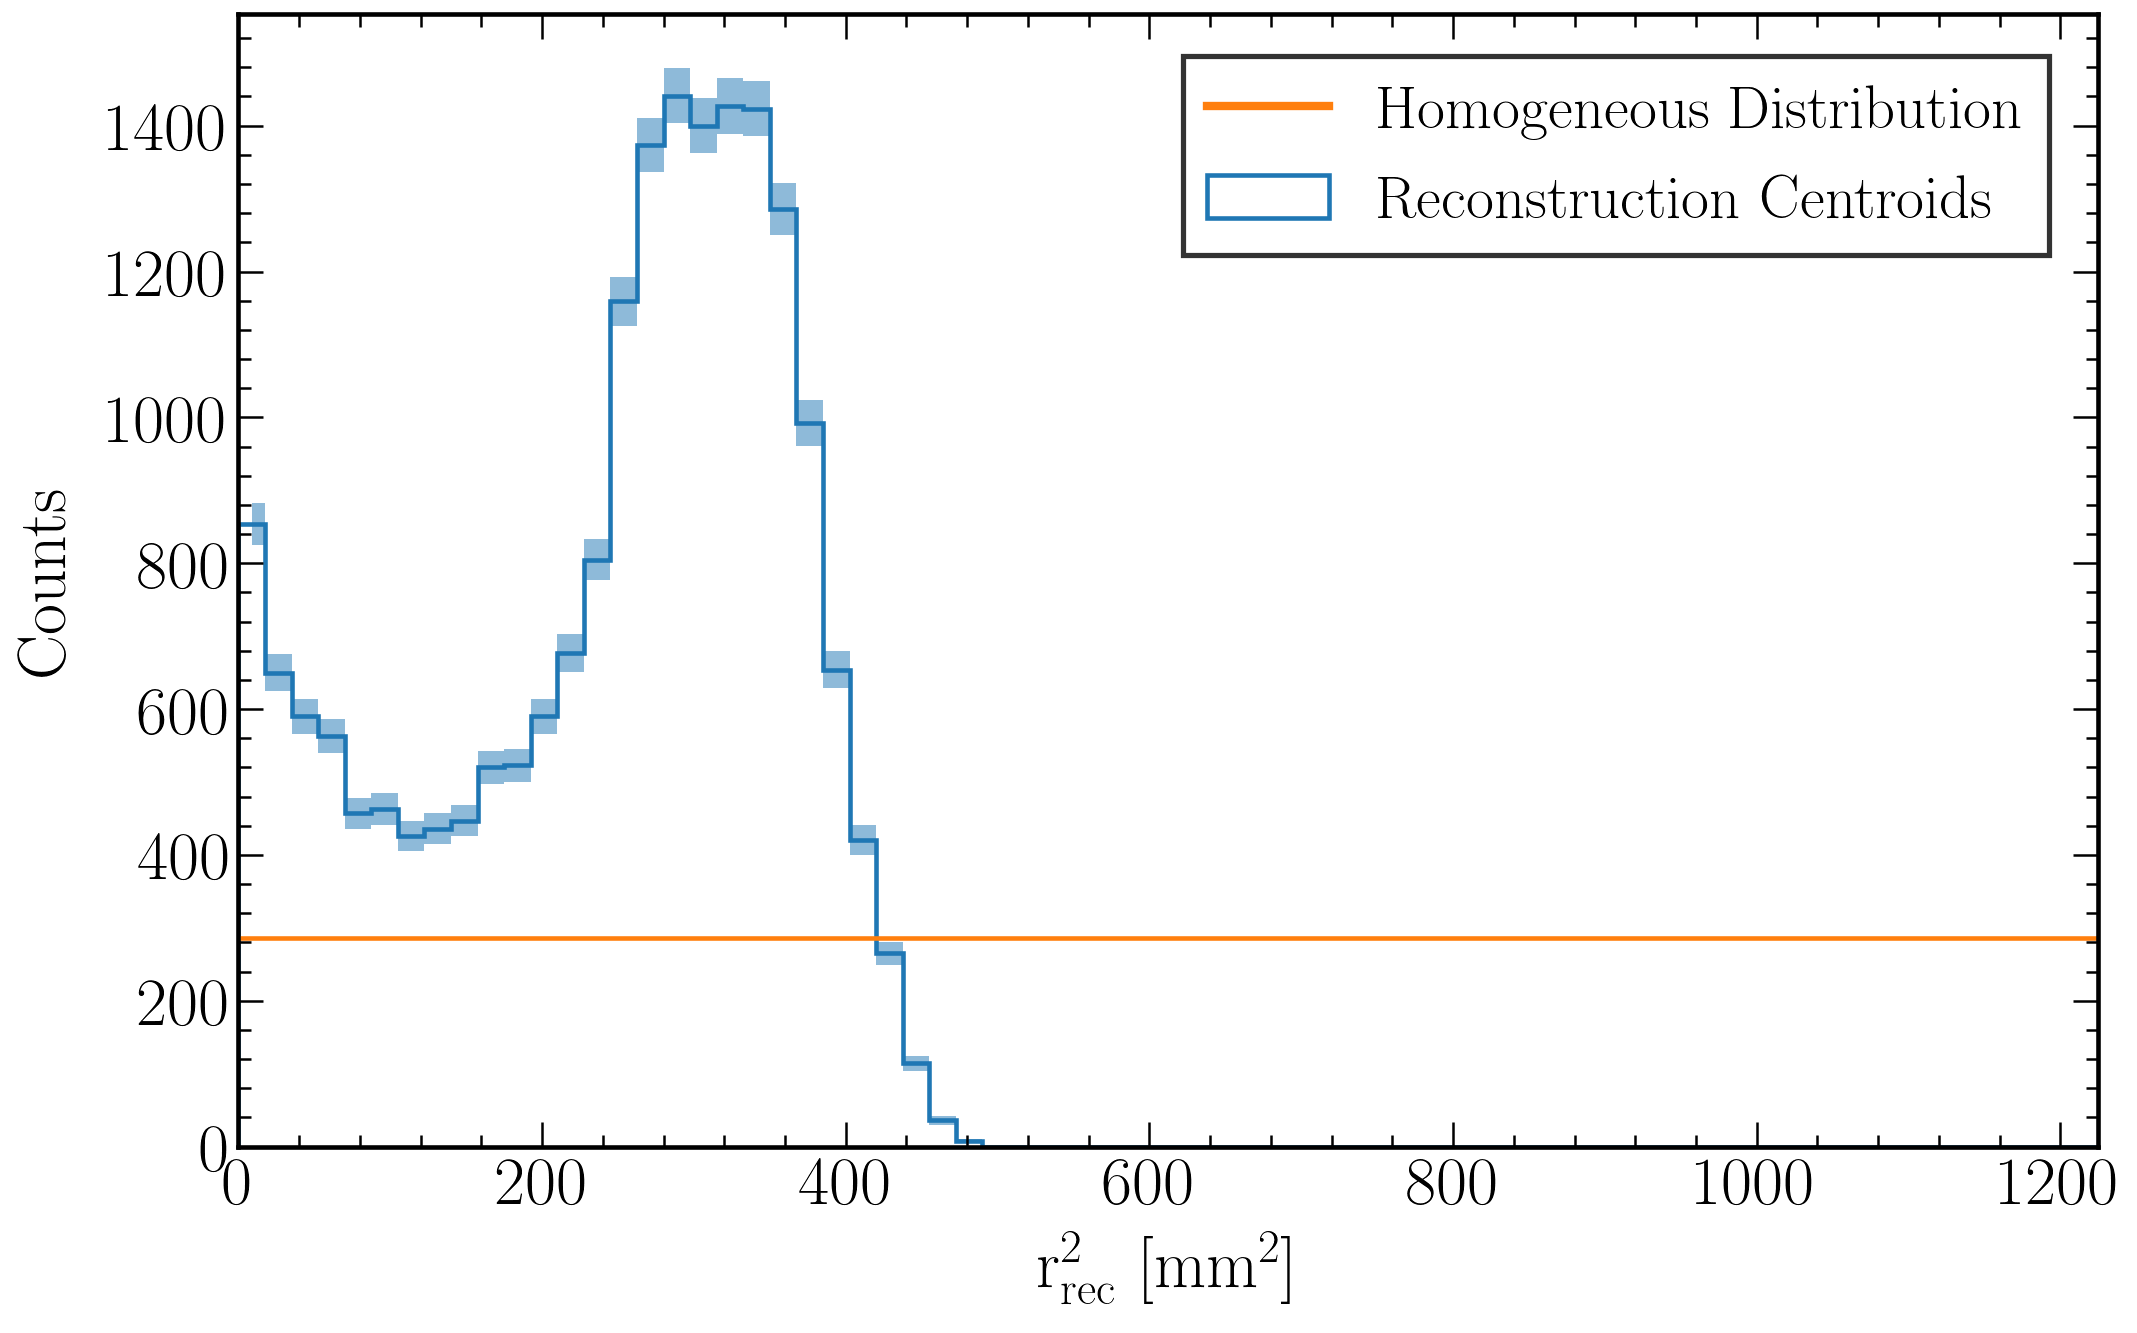

In [14]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.plot([0, 35**2], [x_list.shape[0]/bns]*2, linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous Distribution')

n, bins, *patches = plt.hist(np.hypot(x_list, y_list)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction Centroids')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C0', 
                 alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35**2)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_Centroid_r2spectrum_witherror.png")
plt.show()

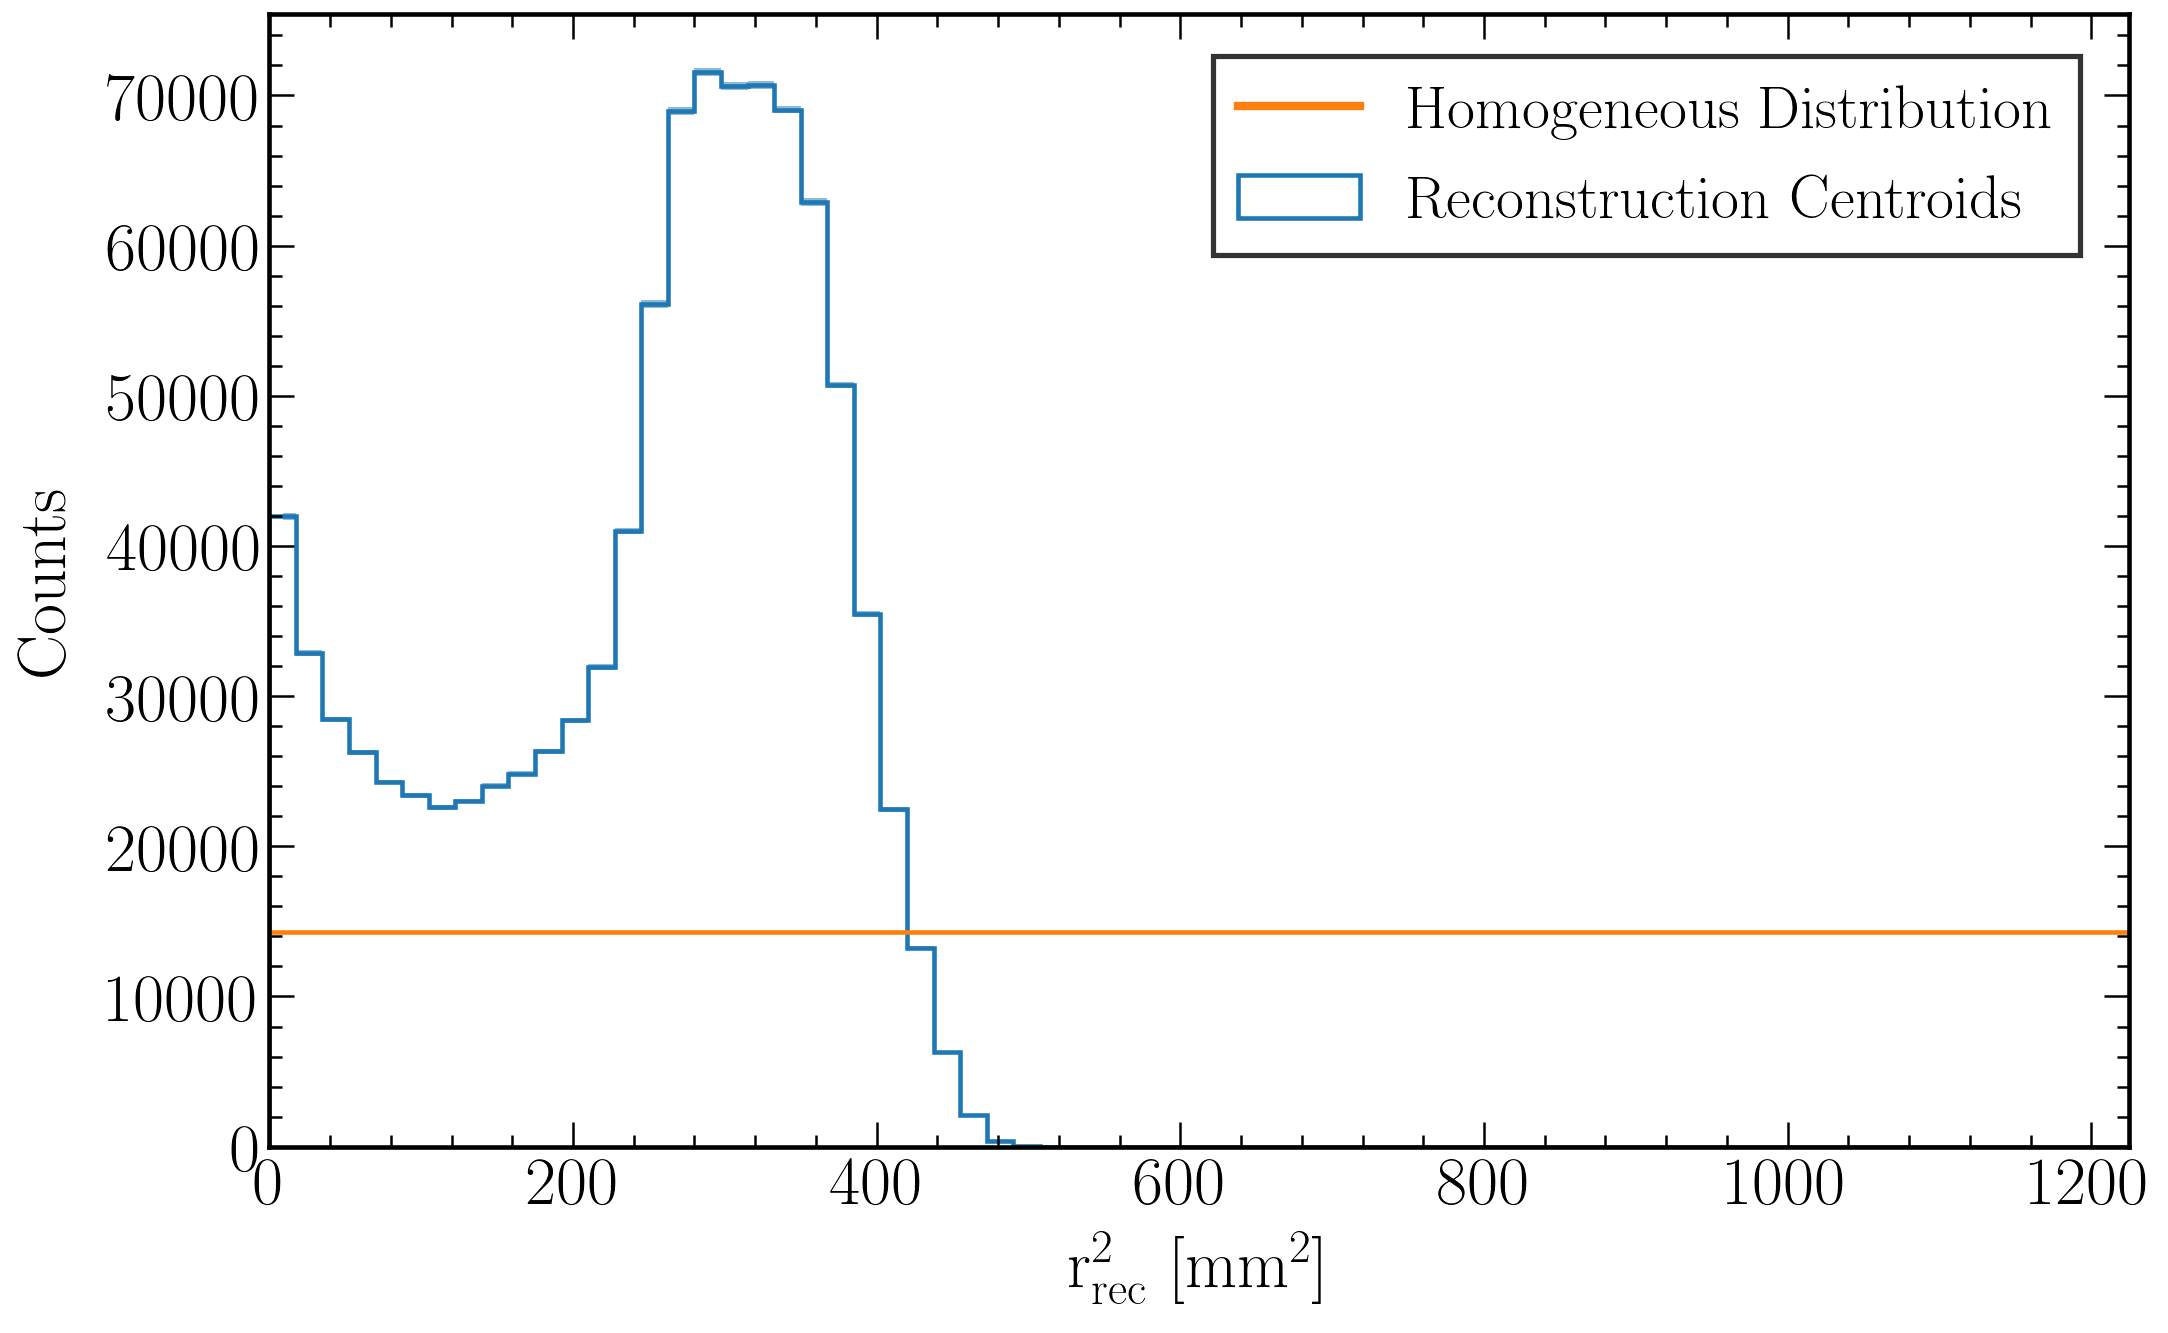

In [15]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.plot([0, 35**2], [x_list_full.shape[0]/bns]*2, linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous Distribution')

n, bins, *patches = plt.hist(np.hypot(x_list_full, y_list_full)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction Centroids')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C0', 
                 alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35**2)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_Centroid_full_r2spectrum_witherror.png")
plt.show()

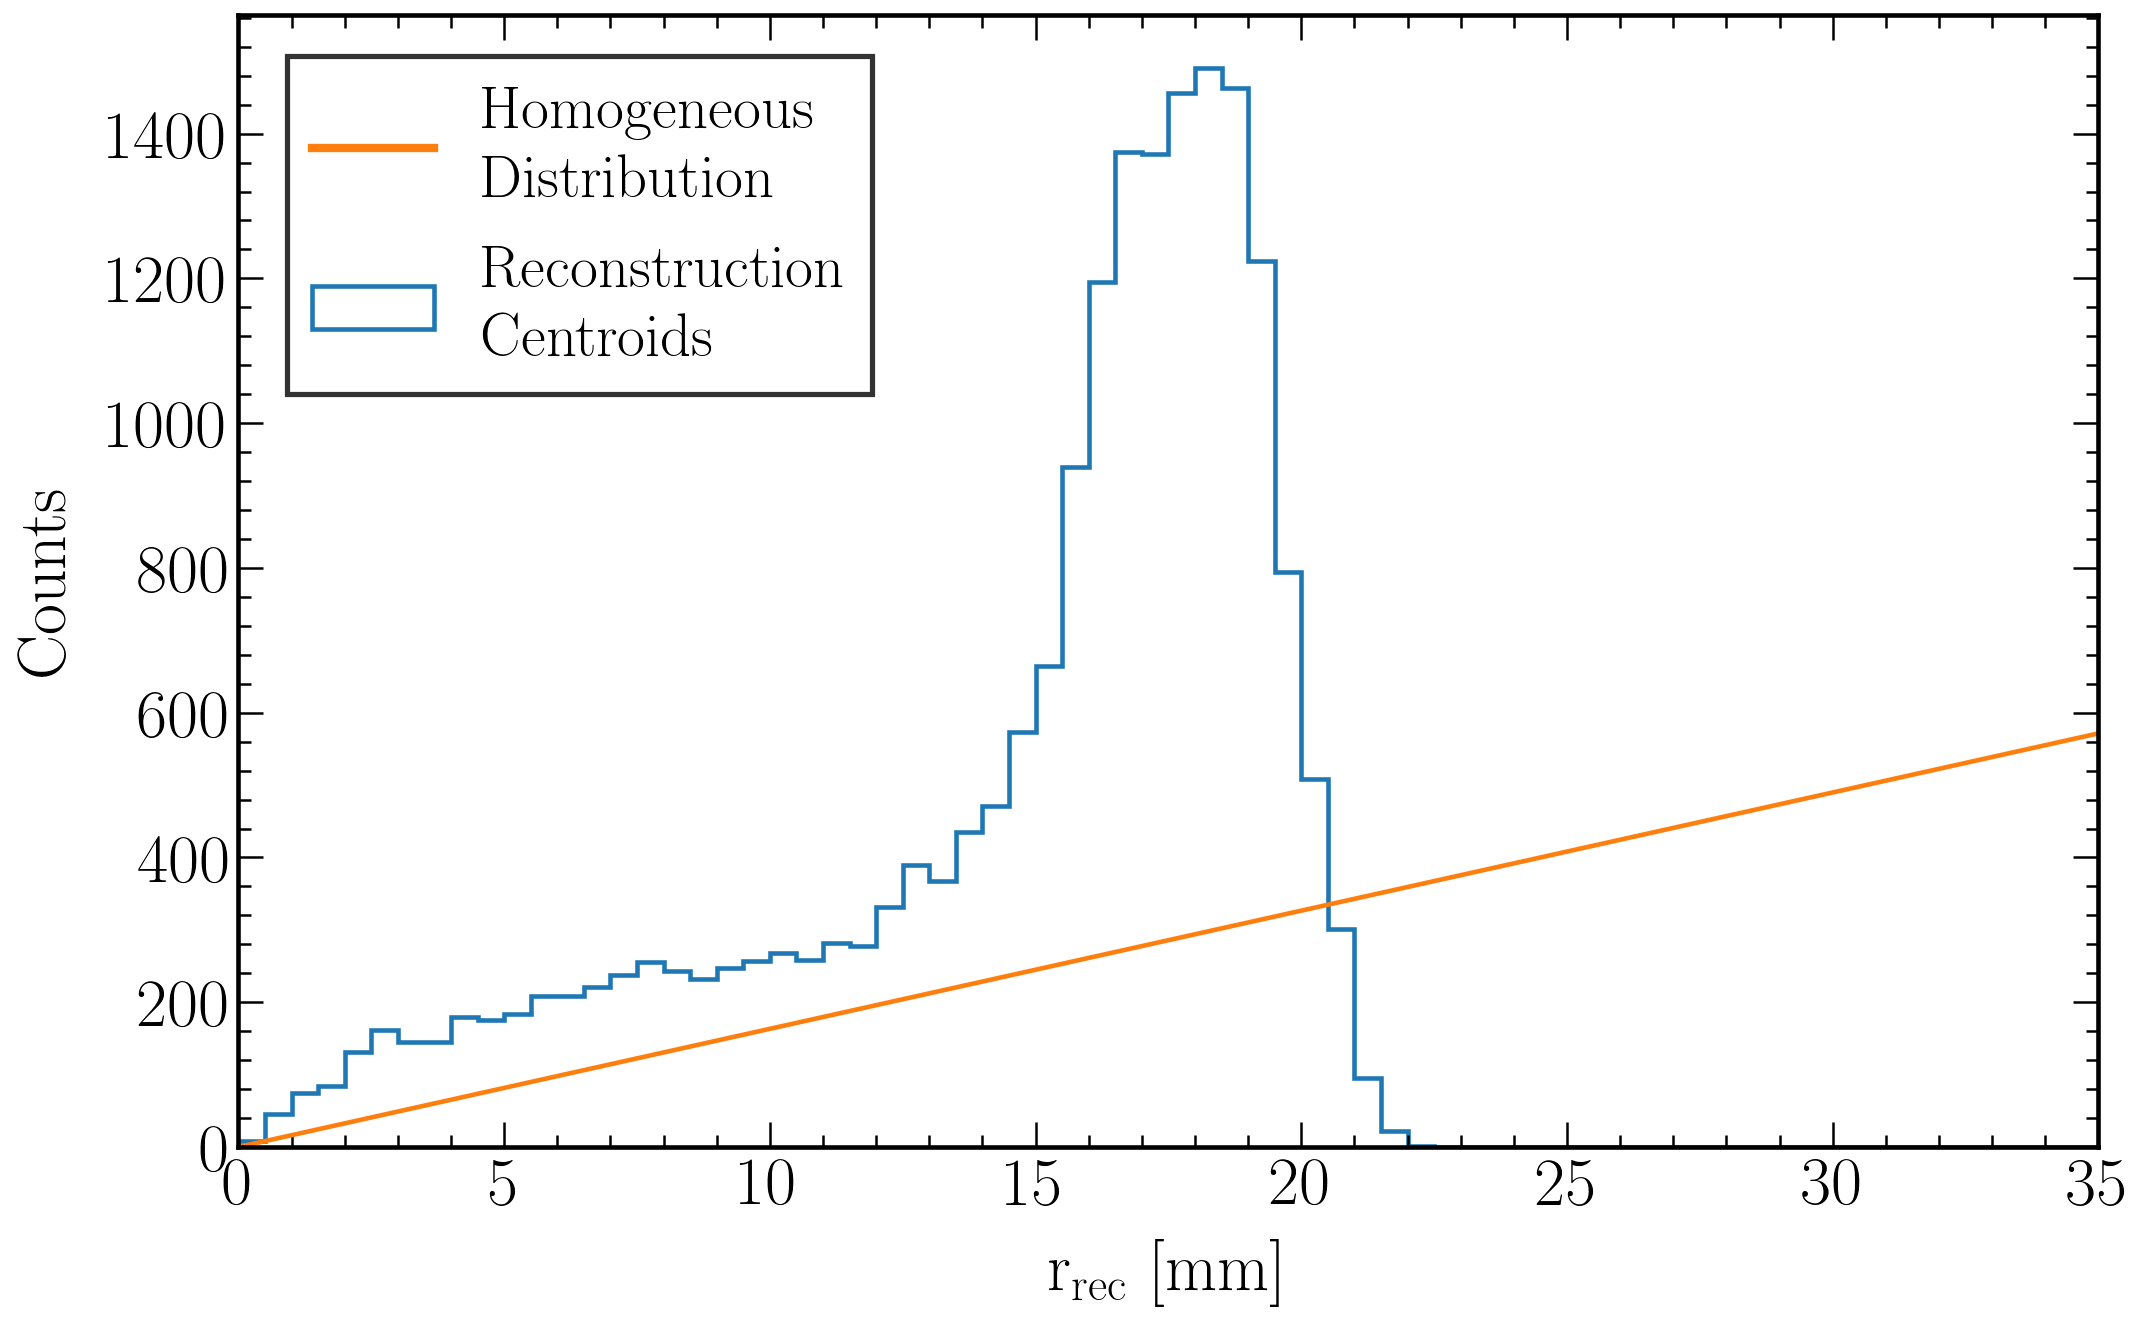

In [16]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.hist(np.hypot(x_list, y_list), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction\nCentroids')
plt.plot([0, 35], [0, bns/35*x_list.shape[0]/bns], linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous\nDistribution')

plt.xlabel('r$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_Centroid_rspectrum.png")
plt.show()

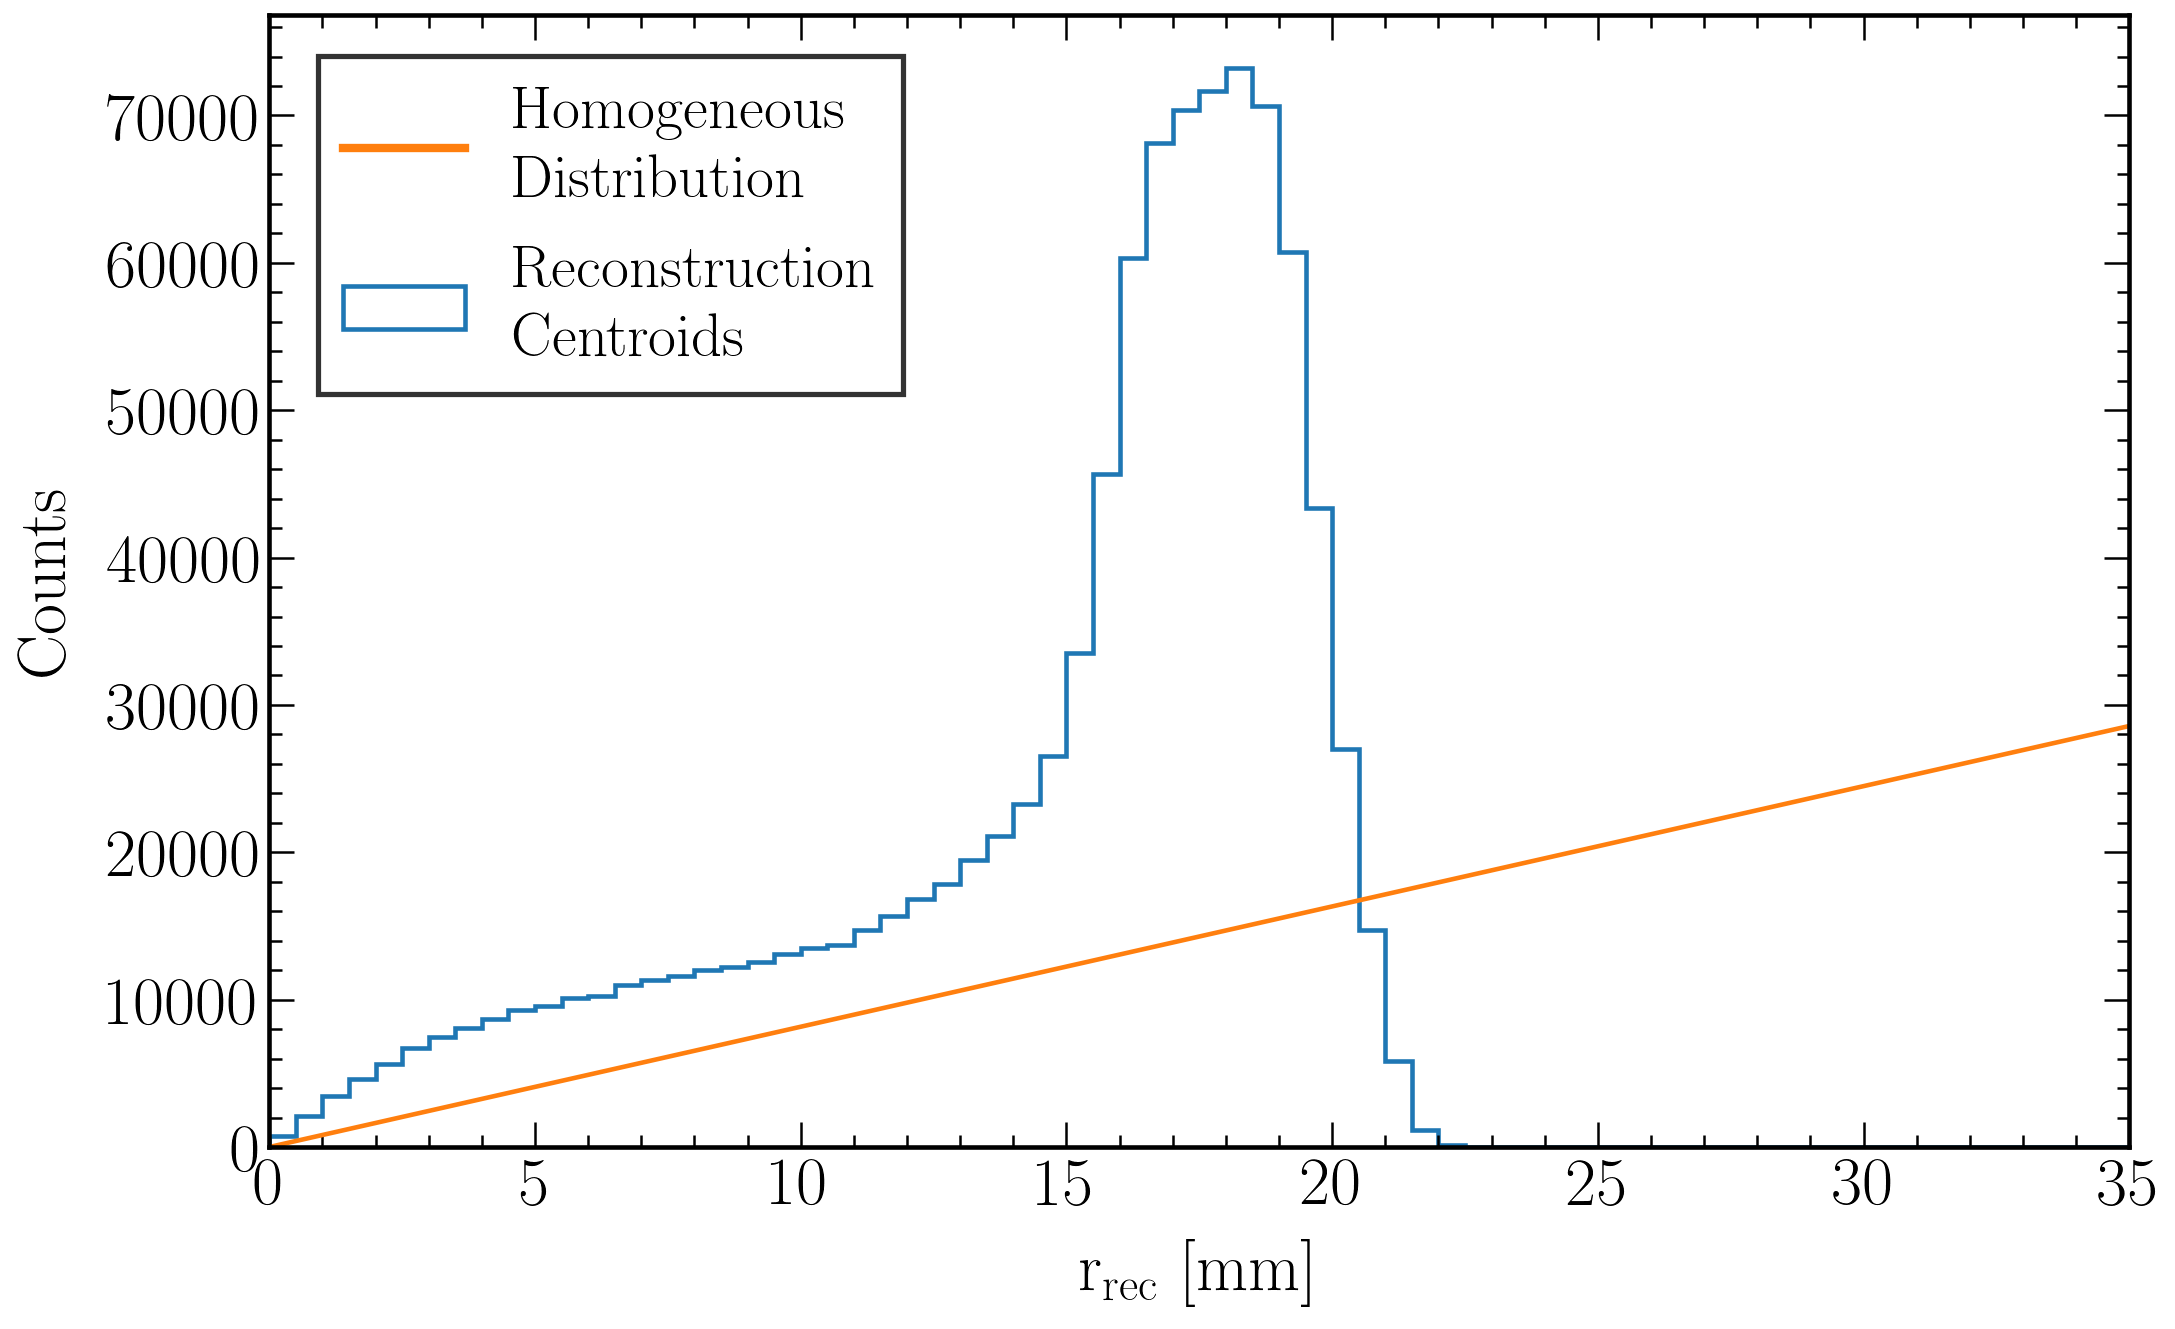

In [17]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.hist(np.hypot(x_list_full, y_list_full), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction\nCentroids')
plt.plot([0, 35], [0, bns/35*x_list_full.shape[0]/bns], linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous\nDistribution')

plt.xlabel('r$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_Centroid_full_rspectrum.png")
plt.show()

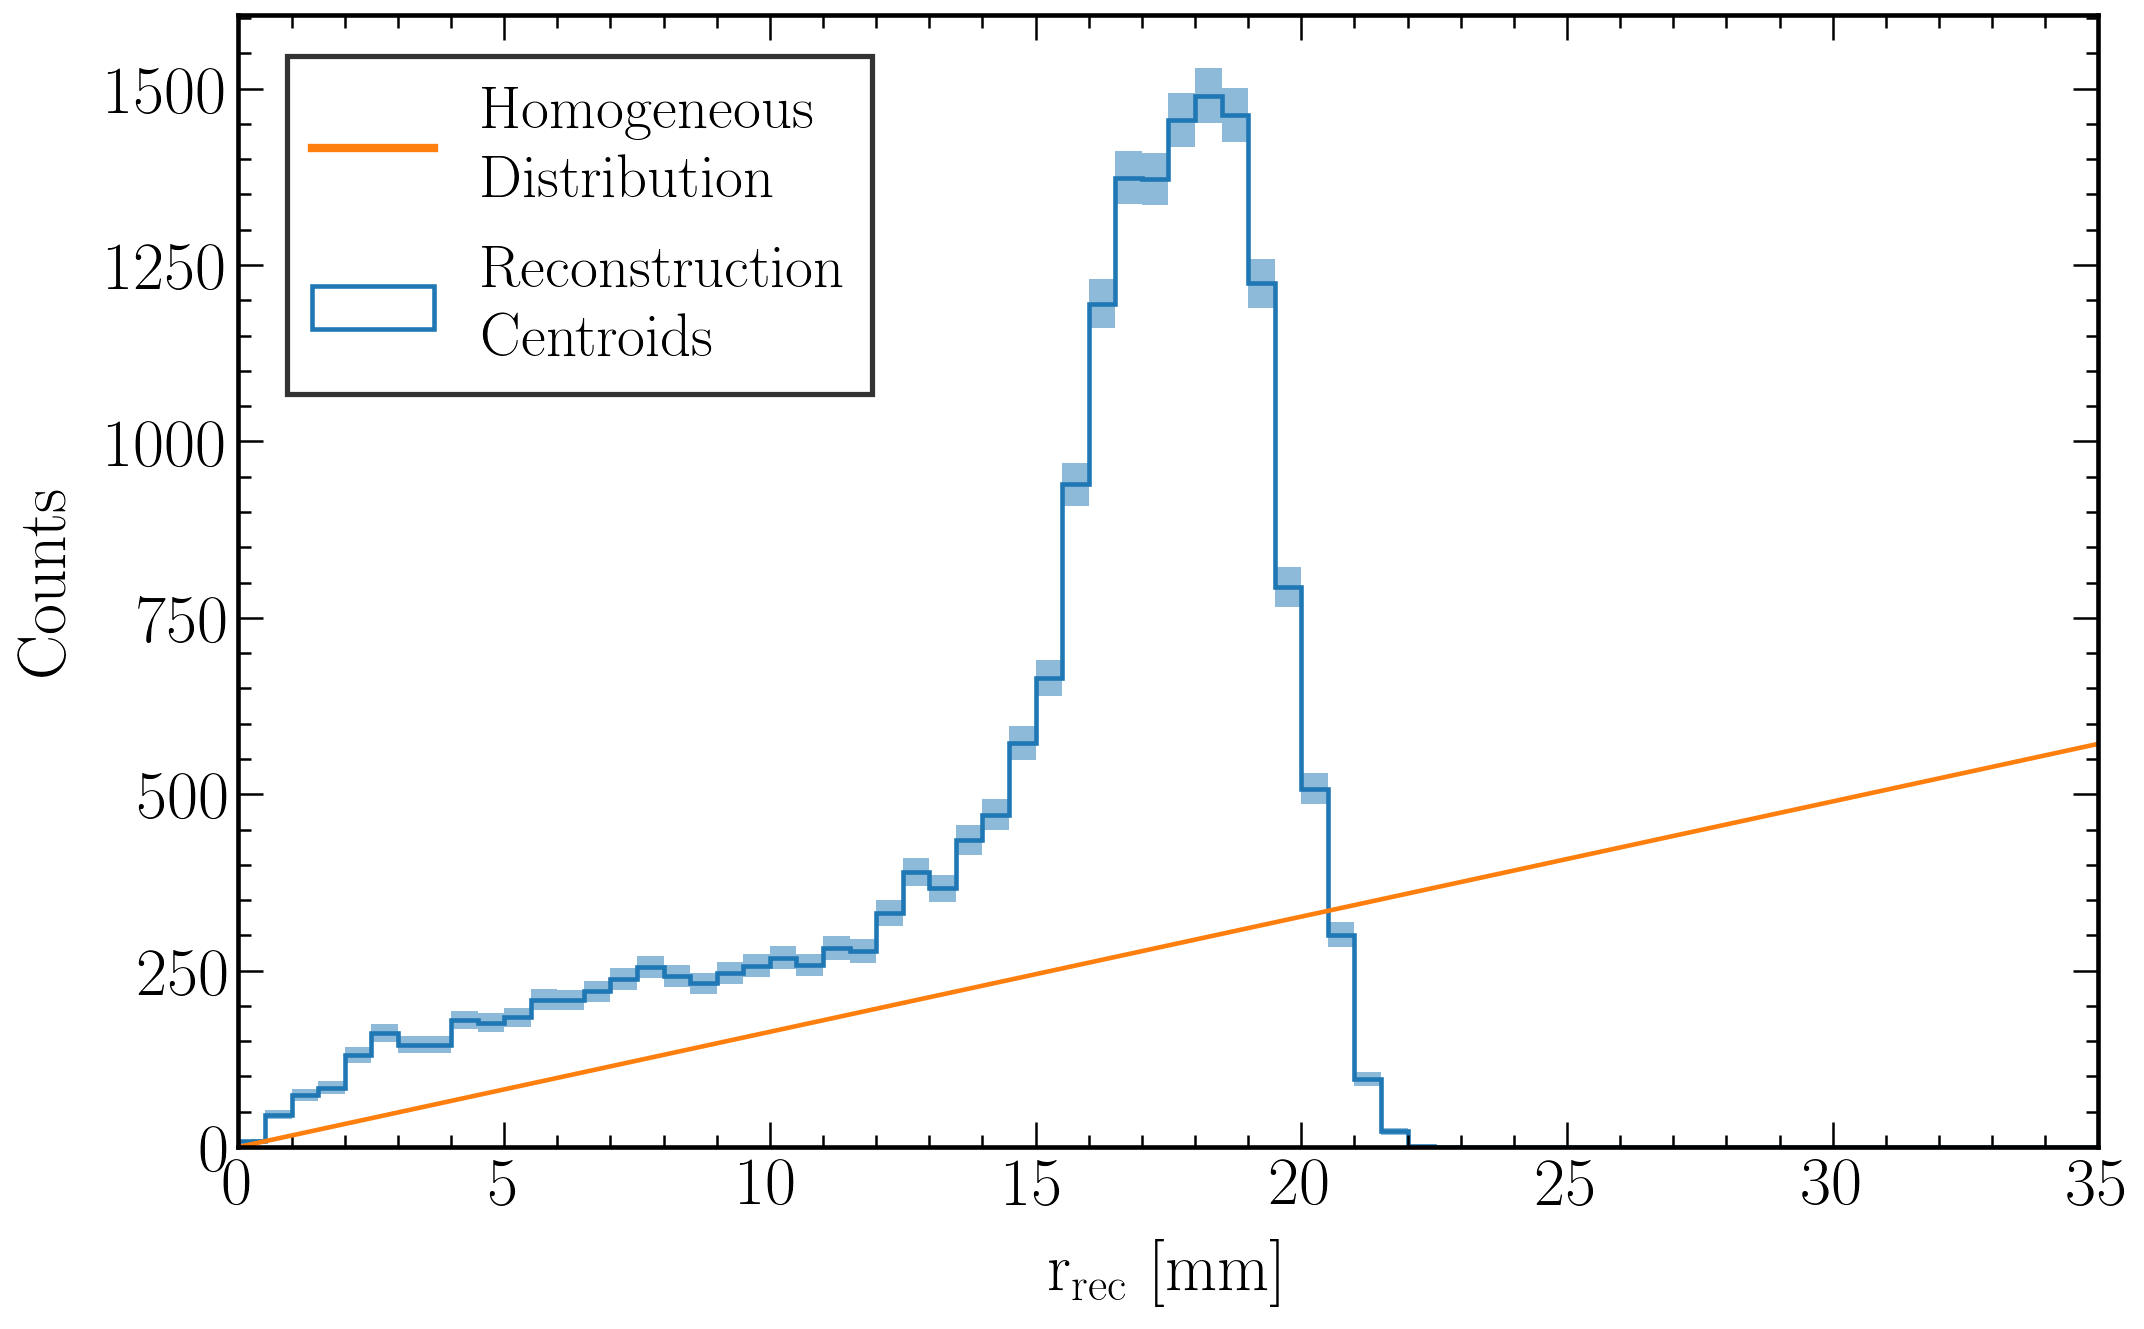

In [18]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.plot([0, 35], [0, bns/35*x_list.shape[0]/bns], linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous\nDistribution')

n, bins, *patches = plt.hist(np.hypot(x_list, y_list), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction\nCentroids')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C0', 
                 alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_Centroid_rspectrum_witherror.png")
plt.show()

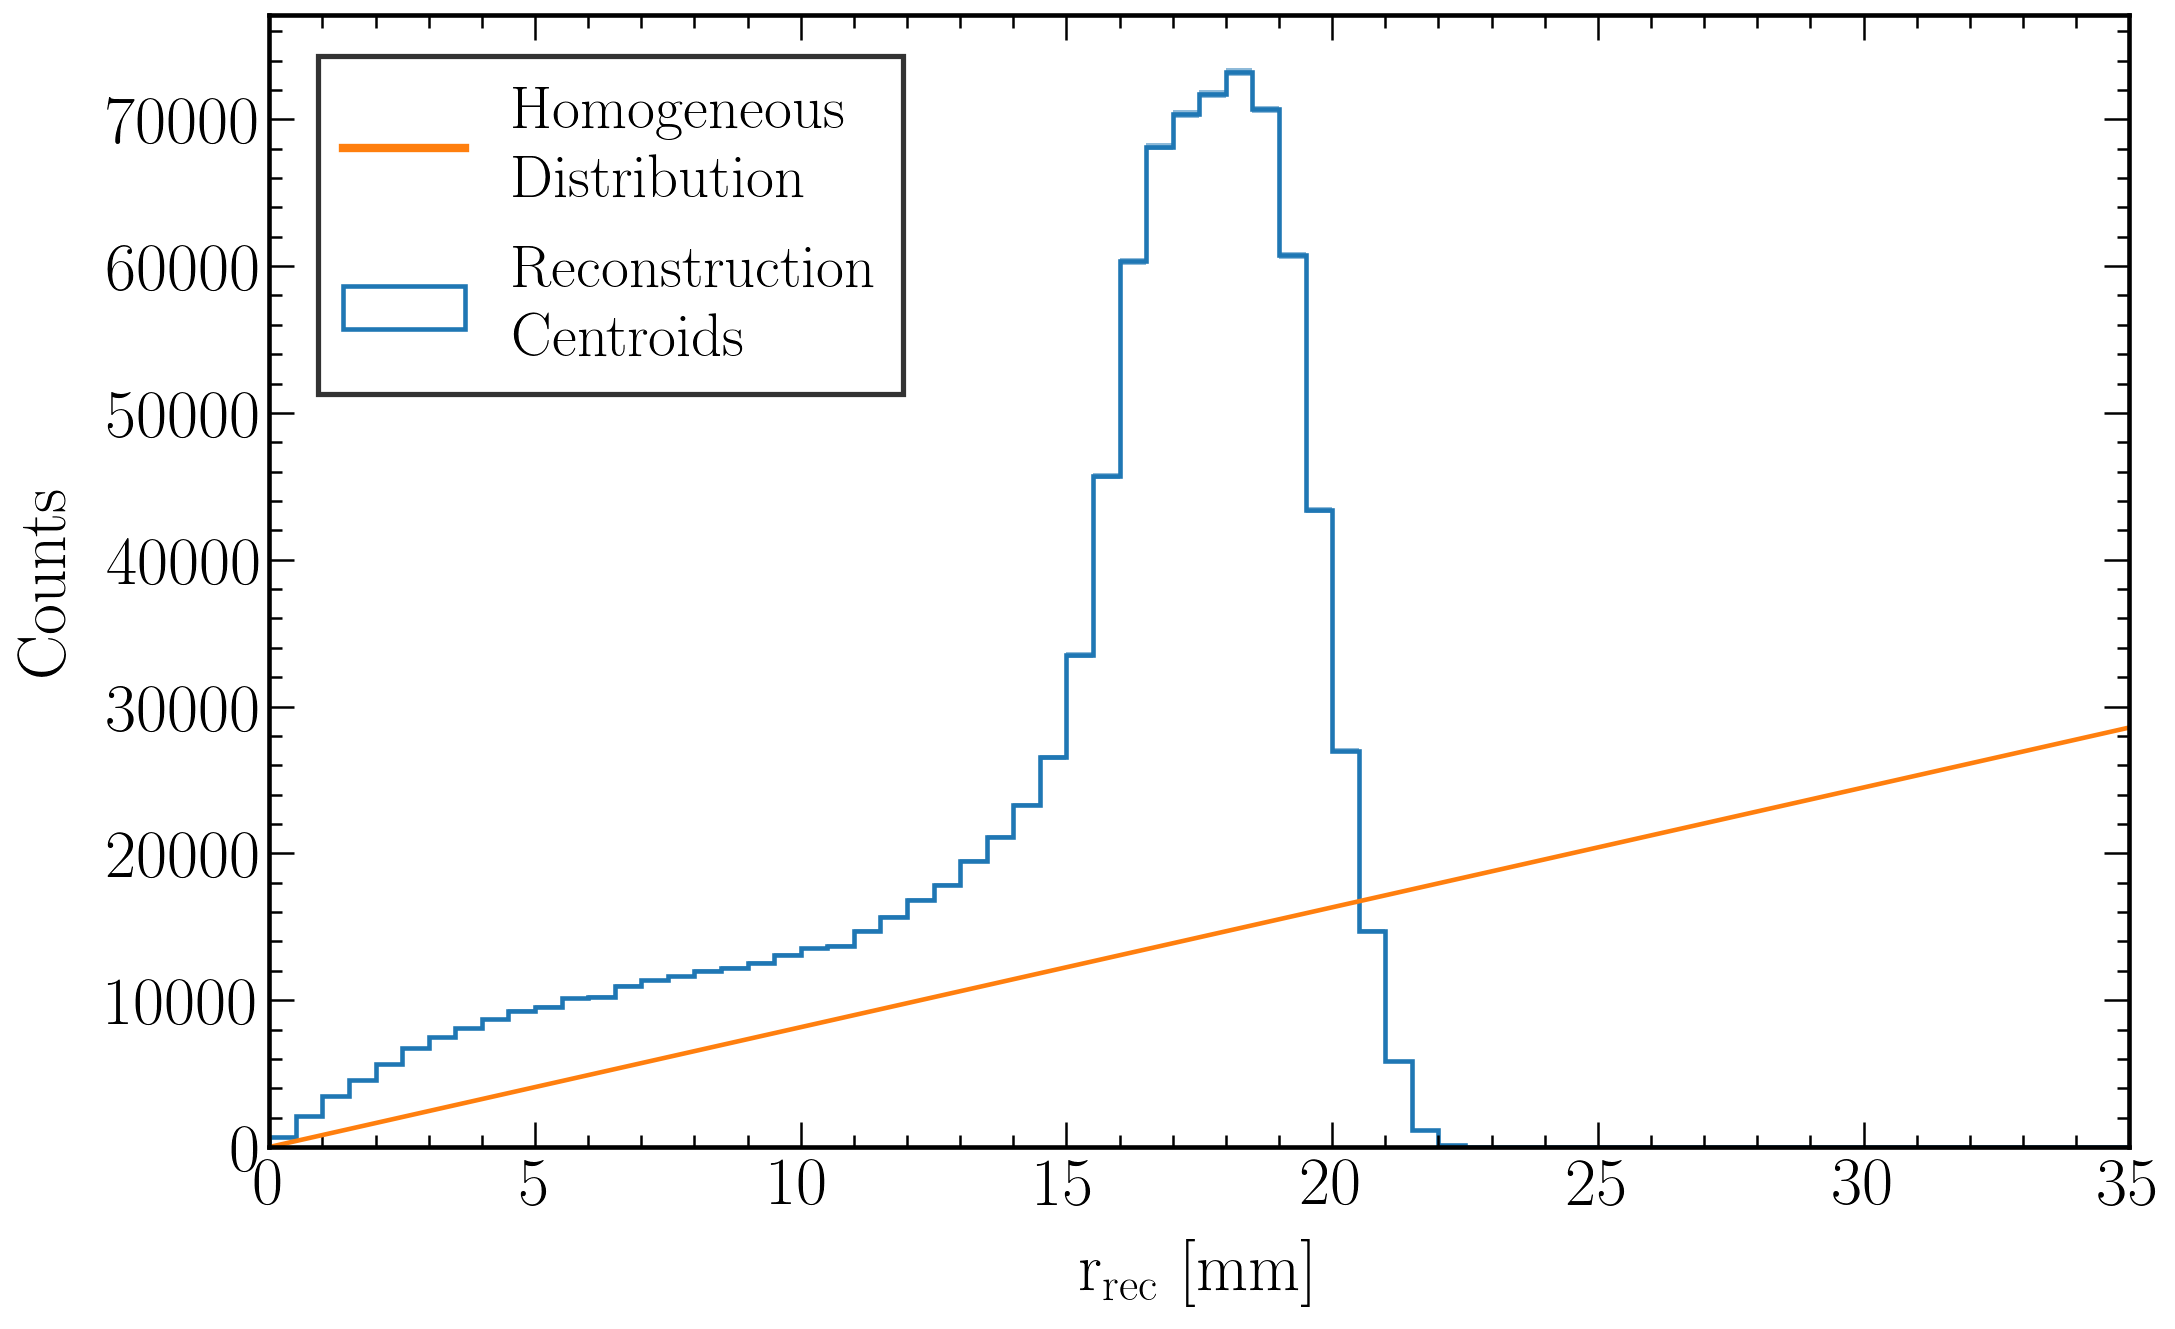

In [19]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.plot([0, 35], [0, bns/35*x_list_full.shape[0]/bns], linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous\nDistribution')

n, bins, *patches = plt.hist(np.hypot(x_list_full, y_list_full), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction\nCentroids')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C0', 
                 alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_Centroid_full_rspectrum_witherror.png")
plt.show()